# Coefficient Estimation for NEWT

At this point, we have established that, with the available periods-of-record, a stationary SCHEMA works quite well, though some sort of dynamism is likely to help with longer-range applications.  Still, the emphasis is on short-term and S2S forecasting, so long-range efficiency isn't critical (and, more to the point, can be returned to later).  Now, let's look at coefficient estimation, where dynamic fitting is likely to be more important.

Here's the basic idea.  We want to be able to run a watershed model without pre-feeding years of data, but we also want to benefit from data on atmospheric conditions.  How should we proceed?

- Develop one fit for model coefficients based only on static surface conditions (XYZ, slope and aspect, land cover/LAI, drainage area)
- Develop a separate fit for model coefficients based only on dynamic conditions (mean precipitation, temperature, and humidity; land cover/LAI again; soil moisture; aridity)
- Tune two "drift rates": climate drift (rate of convergence from static-only to climate-only; possibly with a final equilibrium weighting), and recency weight (weighting of climate over time, controlling speed of correction for climate shifts)

For early reporting, I will prototype this with a single model accounting for all data.  Then, I'll build a static-only watershed model generator and a climate-drift model modification engine for the final implementation.

Data requirements:

- Model fits (have)
- Weather data (have)
- Land cover/LAI (have)
- Soil moisture (need)
- Topography summaries (have)
- Aridity (need)

In [33]:
import pandas as pd
import pandas.plotting as pdp
import numpy as np
import matplotlib.pyplot as plt
import rtseason as rts
import seaborn as sns
import scipy
from sklearn.decomposition import PCA
from NEWT import Watershed, kfold, perf_summary, statics

In [2]:
def idfix(data):
    data = data[data["id"].apply(lambda x: x.startswith("USGS"))]
    data["id"] = data["id"].apply(lambda x: x.split("_")[1])
    return data

In [3]:
# sillymod: use one generic model.  Otherwise, fit each model to itself.
def dummy_modbuilder(data, sillymod):
    data = data.groupby("date")[["temperature", "tmax", "vp"]].mean().assign(date = lambda x: x.index)
    def runner(ws):
        try:
            if sillymod:
                return Watershed.from_data(data).run_series(ws)
            else:
                return Watershed.from_data(ws).run_series(ws)
        except Exception as e:
            print(e)
    return runner

In [9]:
data = pd.read_csv("AllData.csv", dtype={"id": "str"}).rename(columns={"temperature.mean": "temperature"})
data["date"] = pd.to_datetime(data["date"])
data["day"] = data["date"].dt.day_of_year
gsamp = pd.read_csv(r"C:\Users\dphilippus\OneDrive - Colorado School of Mines\PhD\NEXT\DataRetrieval\GageSample.csv",
                   dtype={"id": "str"})
lcov = idfix(pd.read_csv("LandCover.csv"))
area = idfix(pd.read_csv("Area.csv"))
topo = idfix(pd.read_csv("Topography.csv"))
data = data.merge(lcov, on="id").merge(area, on="id").merge(topo, on="id").merge(gsamp[["id", "lat", "lon"]], on="id")
data

,id,date,temperature,prcp,srad,swe,tmax,tmin,vp,day,...,wetland,ice_snow,area,elev,elev_min,elev_std,slope,asp,lat,lon
0,13011820,2020-03-31,0.100000,17.110126,248.76216,NaN,1.795443,NaN,444.26370,91,...,0.040230,0.0,7.993837e+07,2868.2670,2549.556152,130.430969,NaN,NaN,43.807111,-110.178722
1,13011820,2020-04-01,0.100000,7.202532,403.38873,NaN,0.030759,NaN,270.94354,92,...,0.040230,0.0,7.993837e+07,2868.2670,2549.556152,130.430969,NaN,NaN,43.807111,-110.178722
2,13011820,2020-04-02,0.100000,2.167848,600.86993,NaN,-3.442405,NaN,132.77936,93,...,0.040230,0.0,7.993837e+07,2868.2670,2549.556152,130.430969,NaN,NaN,43.807111,-110.178722
3,13011820,2020-04-03,0.100000,2.987468,509.44165,NaN,-2.238481,NaN,138.35303,94,...,0.040230,0.0,7.993837e+07,2868.2670,2549.556152,130.430969,NaN,NaN,43.807111,-110.178722
4,13011820,2020-04-04,0.100000,6.021518,465.97583,NaN,3.509114,NaN,284.43704,95,...,0.040230,0.0,7.993837e+07,2868.2670,2549.556152,130.430969,NaN,NaN,43.807111,-110.178722
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2992992,03047000,2022-12-27,0.540625,0.000000,268.23563,NaN,-2.151775,NaN,207.79785,361,...,0.003176,0.0,6.878668e+08,457.4157,257.871948,133.578278,NaN,NaN,40.458889,-79.449444
2992993,03047000,2022-12-28,0.407292,0.000000,279.93356,NaN,5.509683,NaN,310.02664,362,...,0.003176,0.0,6.878668e+08,457.4157,257.871948,133.578278,NaN,NaN,40.458889,-79.449444
2992994,03047000,2022-12-29,0.428125,0.000000,290.53482,NaN,13.100331,NaN,354.31638,363,...,0.003176,0.0,6.878668e+08,457.4157,257.871948,133.578278,NaN,NaN,40.458889,-79.449444
2992995,03047000,2022-12-30,0.661458,0.000000,285.53320,NaN,17.568270,NaN,512.88240,364,...,0.003176,0.0,6.878668e+08,457.4157,257.871948,133.578278,NaN,NaN,40.458889,-79.449444


## A Silly Kfold Test

First we need to test the cross-validation setup, so we have a dummy model to test it with.  One option is to use a model that's just trained on everything.  The other option is to use a model that's trained on each watershed to predict itself.

In [5]:
silly = kfold(data, lambda x: dummy_modbuilder(x, True), output="results/Silly.csv")
cheat = kfold(data, lambda x: dummy_modbuilder(x, False), output="results/Cheat.csv")

In [6]:
silly.groupby("id").apply(perf_summary, include_groups=False).median()

R2         0.927358
RMSE       2.889678
NSE        0.810347
Pbias      2.989468
Bias       0.369906
MaxMiss    1.845938
dtype: float64

## Prepare Coefficients

Since the kfold testing seems to be working, let's prepare model coefficients.  To recap, we need to provide seasonality coefficients, tmax and vp sensitivities, and tmax and vp dailies (for static/spin-up).  We can also set up dynamic and yearly modification engines, and will eventually separate estimators into static (at start) and climate/dynamic (through a climate modification engine), but that can come later.

A brief test was run and subsequently deleted to establish that simple sinusoid (annual-period, variable-phase sine) does a solid job capturing vp and tmax annual cycles (median R2 0.95 and 0.92, respectively), and therefore those coefficients are suitable here.

In [90]:
coefs = data.groupby("id").apply(lambda x: (
    pd.concat([
        Watershed.from_data(x).coefs_to_df().drop(columns=["R2", "RMSE"]),
        statics.fit_simple_daily(x, "tmax", True).\
        merge(statics.fit_simple_daily(x, "vp", True), how="cross", suffixes=("_tm", "_vp"))
    ], axis=1)
) if len(x[["day", "temperature"]].dropna()["day"].unique()) >= 181 else None, include_groups=False)
coefs.index = coefs.index.get_level_values("id")
coefs

,Intercept,Amplitude,FallDay,WinterDay,SpringDay,SummerDay,SpringSummer,FallWinter,at_coef,vp_coef,intercept_tm,ksin_tm,kcos_tm,intercept_vp,ksin_vp,kcos_vp
id,,,,,,,,,,,,,,,,
01010000,8.227527,11.664508,323.0,27.5,120.0,236.0,1.989669,3.269881,0.275727,0.001378,8.787829,-6.067253,-15.167896,693.766616,-266.789732,-570.140506
01011000,8.547659,11.735706,322.0,27.0,120.0,204.0,2.563314,2.746746,0.255334,0.001096,9.763696,-5.932321,-14.604735,699.838476,-263.185827,-560.410490
01018035,9.074948,12.007753,321.0,28.0,120.0,206.0,1.838306,2.569034,0.315614,0.001516,11.344458,-5.606314,-14.288229,766.456060,-289.078520,-584.337550
01038000,10.871231,12.433309,319.0,27.0,169.0,200.0,0.899632,1.966065,0.333966,0.001423,12.411499,-5.377854,-12.851322,880.149454,-319.869872,-646.207066
010642505,8.232986,9.252760,321.0,26.0,122.0,233.0,1.766506,1.030557,0.271311,0.001534,10.084860,-5.104671,-12.878405,718.774950,-241.243771,-548.664202
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
385903107210800,7.163091,9.258731,300.0,87.0,143.0,201.0,2.083604,1.409694,0.478011,-0.000085,11.893447,-4.284127,-11.356781,574.381380,-190.504921,-319.363068
394220106431500,6.965011,7.357272,324.0,84.0,156.0,237.0,2.823831,1.979052,0.307356,0.000265,9.466164,-3.972916,-10.774711,516.589866,-135.047240,-276.552819
402114105350101,4.352286,7.339022,301.0,88.0,153.0,237.0,2.495065,0.984321,0.384537,0.000378,6.876817,-4.462743,-11.078878,476.261802,-147.476692,-304.520152


In [28]:
coefs.corr()

,Intercept,Amplitude,FallDay,WinterDay,SpringDay,SummerDay,SpringSummer,FallWinter,at_coef,vp_coef,intercept_tm,ksin_tm,kcos_tm,intercept_vp,ksin_vp,kcos_vp
Intercept,1.000000,0.087094,0.168131,0.368204,0.324701,0.118031,-0.126292,0.086805,-0.055153,0.487779,0.735301,0.491618,0.316336,0.623298,-0.305323,-0.420201
Amplitude,0.087094,1.000000,-0.377537,0.273869,-0.067101,-0.271086,-0.227748,0.472257,0.453893,0.058314,-0.018569,-0.310002,-0.587390,0.063076,-0.478376,-0.434878
FallDay,0.168131,-0.377537,1.000000,-0.143717,0.102672,0.354318,0.043403,-0.407274,-0.310416,-0.053592,0.233559,0.246466,0.279176,0.149529,0.091839,0.029330
WinterDay,0.368204,0.273869,-0.143717,1.000000,0.424919,-0.199596,-0.323925,0.209612,0.353000,0.166050,0.395433,0.156092,0.047770,0.294704,-0.260172,-0.310692
SpringDay,0.324701,-0.067101,0.102672,0.424919,1.000000,0.148042,-0.224463,0.021307,0.162912,0.064498,0.424221,0.409479,0.277801,0.359283,-0.139890,-0.221989
SummerDay,0.118031,-0.271086,0.354318,-0.199596,0.148042,1.000000,0.157056,-0.443811,-0.215468,-0.094063,0.130819,0.234841,0.271242,0.188233,-0.066512,-0.074314
SpringSummer,-0.126292,-0.227748,0.043403,-0.323925,-0.224463,0.157056,1.000000,-0.117596,-0.546726,0.208749,-0.507914,-0.206541,-0.029938,-0.488457,0.363564,0.445504
FallWinter,0.086805,0.472257,-0.407274,0.209612,0.021307,-0.443811,-0.117596,1.000000,0.365754,0.126217,0.027942,-0.046979,-0.233083,-0.112976,-0.024488,0.052592
at_coef,-0.055153,0.453893,-0.310416,0.353000,0.162912,-0.215468,-0.546726,0.365754,1.000000,-0.517395,0.311382,0.148405,0.022100,0.303682,-0.323607,-0.316742
vp_coef,0.487779,0.058314,-0.053592,0.166050,0.064498,-0.094063,0.208749,0.126217,-0.517395,1.000000,0.013892,-0.014610,-0.089812,0.077106,-0.138639,-0.132052


## PCA

In [73]:
co_norm = (coefs - coefs.mean()) / coefs.std()
co_norm.iloc[:, :10]

,,Intercept,Amplitude,FallDay,WinterDay,SpringDay,SummerDay,SpringSummer,FallWinter,at_coef,vp_coef
id,,,,,,,,,,,
01010000,0,-0.943126,1.020460,-0.239062,-1.207480,-1.574790,1.057523,1.185340,2.035952,-0.495313,0.335223
01011000,0,-0.874865,1.046572,-0.303112,-1.222831,-1.574790,-0.790702,1.723365,1.467359,-0.592296,0.137413
01018035,0,-0.762433,1.146347,-0.367163,-1.192130,-1.574790,-0.675188,1.043375,1.274206,-0.305630,0.431983
01038000,0,-0.379418,1.302420,-0.495264,-1.222831,0.691799,-1.021730,0.162987,0.618842,-0.218354,0.366795
010642505,0,-0.941962,0.135945,-0.367163,-1.253531,-1.482276,0.884252,0.976034,-0.397956,-0.516314,0.444743
...,...,...,...,...,...,...,...,...,...,...,...
385903107210800,0,-1.170092,0.138135,-1.712223,0.619173,-0.510881,-0.963973,1.273442,0.014126,0.466665,-0.691027
394220106431500,0,-1.212328,-0.559231,-0.175011,0.527073,0.090459,1.115280,1.967705,0.632957,-0.344901,-0.445304
402114105350101,0,-1.769430,-0.565924,-1.648173,0.649873,-0.048312,1.115280,1.659354,-0.448210,0.022142,-0.365879


There are some nontrivial cross-correlations, so let's see what the principal component axes look like.  Let's limit it to stream properties (10 variables).

In [74]:
pca = PCA()
fit = pca.fit(co_norm.iloc[:, :10])
evr = fit.explained_variance_ratio_
print(evr)
print(np.cumsum(evr))

[0.28635317 0.19484294 0.16747634 0.07725998 0.07444256 0.05951356
 0.0512307  0.0416597  0.03223543 0.01498563]
[0.28635317 0.48119611 0.64867245 0.72593242 0.80037498 0.85988854
 0.91111925 0.95277894 0.98501437 1.        ]


Compared to 10 coefficients, we can capture ~95% of the variance with 8 components.  6 components capture 86%.  Doesn't really seem worth pursuing.

<Axes: >

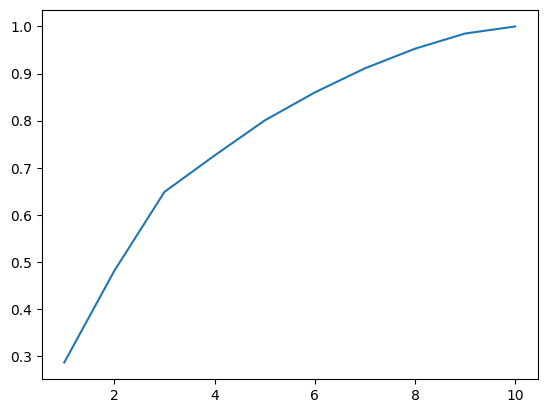

In [75]:
sns.lineplot(x=np.arange(1, len(evr)+1), y=np.cumsum(evr))

## Coefficient Correlations

### Geography

What's predictable from linear XYZ (plus squared longitude, which gives access to "coasts vs middle")?

In [98]:
coef_xyz = coefs.merge(data[["lat", "lon", "elev", "id"]].groupby("id").mean(), on="id").assign(lon2 = lambda x: (x["lon"] - x["lon"].mean())**2)
coef_xyz

,Intercept,Amplitude,FallDay,WinterDay,SpringDay,SummerDay,SpringSummer,FallWinter,at_coef,vp_coef,intercept_tm,ksin_tm,kcos_tm,intercept_vp,ksin_vp,kcos_vp,lat,lon,elev,lon2
id,,,,,,,,,,,,,,,,,,,,
01010000,8.227527,11.664508,323.0,27.5,120.0,236.0,1.989669,3.269881,0.275727,0.001378,8.787829,-6.067253,-15.167896,693.766616,-266.789732,-570.140506,46.700556,-69.715556,421.54080,575.889748
01011000,8.547659,11.735706,322.0,27.0,120.0,204.0,2.563314,2.746746,0.255334,0.001096,9.763696,-5.932321,-14.604735,699.838476,-263.185827,-560.410490,47.069722,-69.079444,362.70602,606.824801
01018035,9.074948,12.007753,321.0,28.0,120.0,206.0,1.838306,2.569034,0.315614,0.001516,11.344458,-5.606314,-14.288229,766.456060,-289.078520,-584.337550,46.181111,-67.803889,175.52219,671.295438
01038000,10.871231,12.433309,319.0,27.0,169.0,200.0,0.899632,1.966065,0.333966,0.001423,12.411499,-5.377854,-12.851322,880.149454,-319.869872,-646.207066,44.222778,-69.593889,109.47253,581.743994
010642505,8.232986,9.252760,321.0,26.0,122.0,233.0,1.766506,1.030557,0.271311,0.001534,10.084860,-5.104671,-12.878405,718.774950,-241.243771,-548.664202,44.083889,-71.285556,704.23030,503.001861
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
385903107210800,7.163091,9.258731,300.0,87.0,143.0,201.0,2.083604,1.409694,0.478011,-0.000085,11.893447,-4.284127,-11.356781,574.381380,-190.504921,-319.363068,38.988361,-107.348489,2647.72120,185.919506
394220106431500,6.965011,7.357272,324.0,84.0,156.0,237.0,2.823831,1.979052,0.307356,0.000265,9.466164,-3.972916,-10.774711,516.589866,-135.047240,-276.552819,39.705000,-106.725833,3027.49410,169.327101
402114105350101,4.352286,7.339022,301.0,88.0,153.0,237.0,2.495065,0.984321,0.384537,0.000378,6.876817,-4.462743,-11.078878,476.261802,-147.476692,-304.520152,40.353861,-105.584139,3229.42850,140.917800


Intercept, Amplitude, SpringSummer, and air temperature variation are partially explained by XYZ, while mean air temperature and all of humidity are quite well explained.  Seasonality dates are very poorly explained.

In [99]:
coef_xyz.corr()[["lat", "lon", "elev", "lon2"]]**2

,lat,lon,elev,lon2
Intercept,0.434484,0.062616,0.170895,0.093716
Amplitude,0.000220,0.244220,0.061939,0.256083
FallDay,0.040251,0.000045,0.009747,0.024269
WinterDay,0.153067,0.048174,0.016780,0.087998
SpringDay,0.167345,0.007364,0.020012,0.022196
SummerDay,0.030443,0.001409,0.002904,0.000012
SpringSummer,0.178378,0.173442,0.234462,0.108312
FallWinter,0.002045,0.010155,0.021177,0.047704
at_coef,0.089587,0.057666,0.034808,0.094770
vp_coef,0.000768,0.028166,0.023897,0.002728
